<a href="https://colab.research.google.com/github/iamnelsonizah/Computer-Vision-Projects-with-Python/blob/main/GROUNDWATER_CENTRAL_KAZAKHSTAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install pymannkendall


In [7]:
!pip install tensorflow

RF Best Parameters: {'max_depth': 15, 'n_estimators': 50}
RF: MAE=7.8392, RMSE=9.7291, R²=0.8743
RF Cross-validated R²: 0.5736 ± 0.2347
XGBoost: MAE=7.3822, RMSE=8.7061, R²=0.8993
XGBoost Cross-validated R²: 0.5945 ± 0.1994
SVR Best Parameters: {'C': 10, 'epsilon': 0.1}
SVR: MAE=16.9050, RMSE=20.0602, R²=0.4655
SVR Cross-validated R²: 0.0096 ± 0.5551
GB Best Parameters: {'learning_rate': 0.1, 'n_estimators': 50}
GB: MAE=7.9988, RMSE=9.4992, R²=0.8802
GB Cross-validated R²: 0.6118 ± 0.1950
LSTM: MAE=8.8625, RMSE=11.8549, R²=0.8098

Random Forest Feature Importance:
Rainfall: 0.0143
Snowfall: 0.0150
Soil Moisture: 0.0197
ET: 0.0321
Temperature: 0.0103
Control Groundwater: 0.8268
Rainfall Lag1: 0.0168
ET Lag1: 0.0098
Soil Moisture Lag1: 0.0174
Month: 0.0378


<ipython-input-12-e8d75c1fdec4>:167: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rf_importances, y=feature_names, palette='viridis')


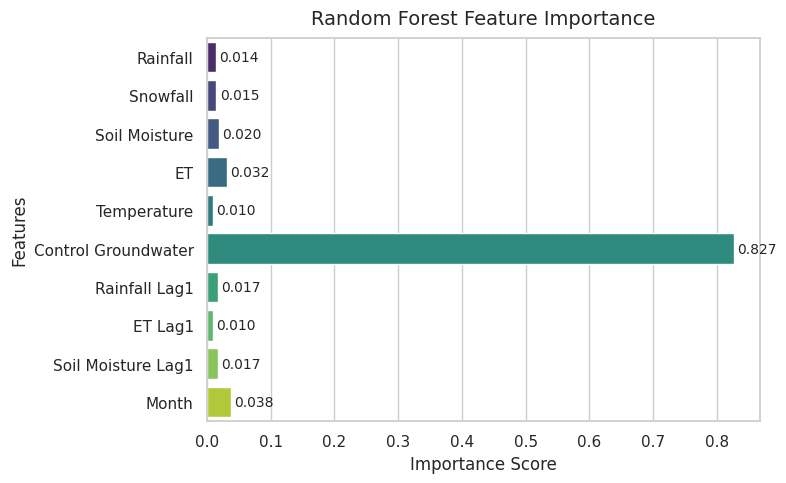


Gradient Boosting Feature Importance:
Rainfall: 0.0111
Snowfall: 0.0152
Soil Moisture: 0.0221
ET: 0.0307
Temperature: 0.0152
Control Groundwater: 0.8365
Rainfall Lag1: 0.0029
ET Lag1: 0.0049
Soil Moisture Lag1: 0.0091
Month: 0.0522


<ipython-input-12-e8d75c1fdec4>:183: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gb_importances, y=feature_names, palette='viridis')


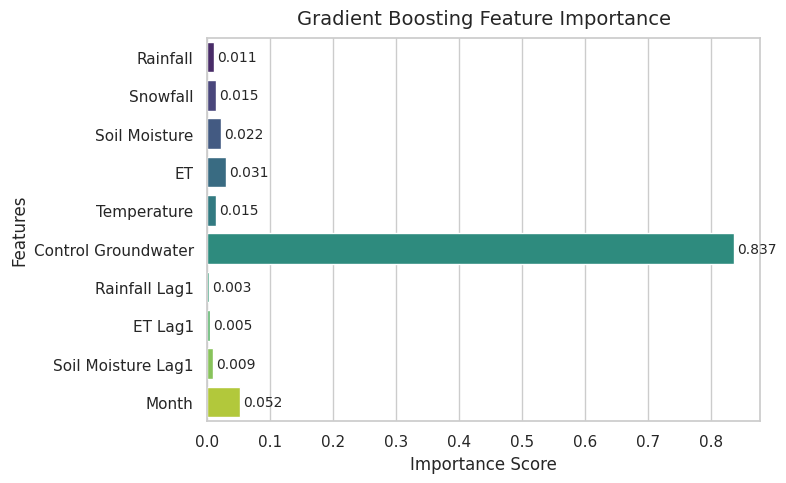

Study Area Mann-Kendall: p=0.1550, slope=-0.3288
Wilcoxon p-value: 0.0000


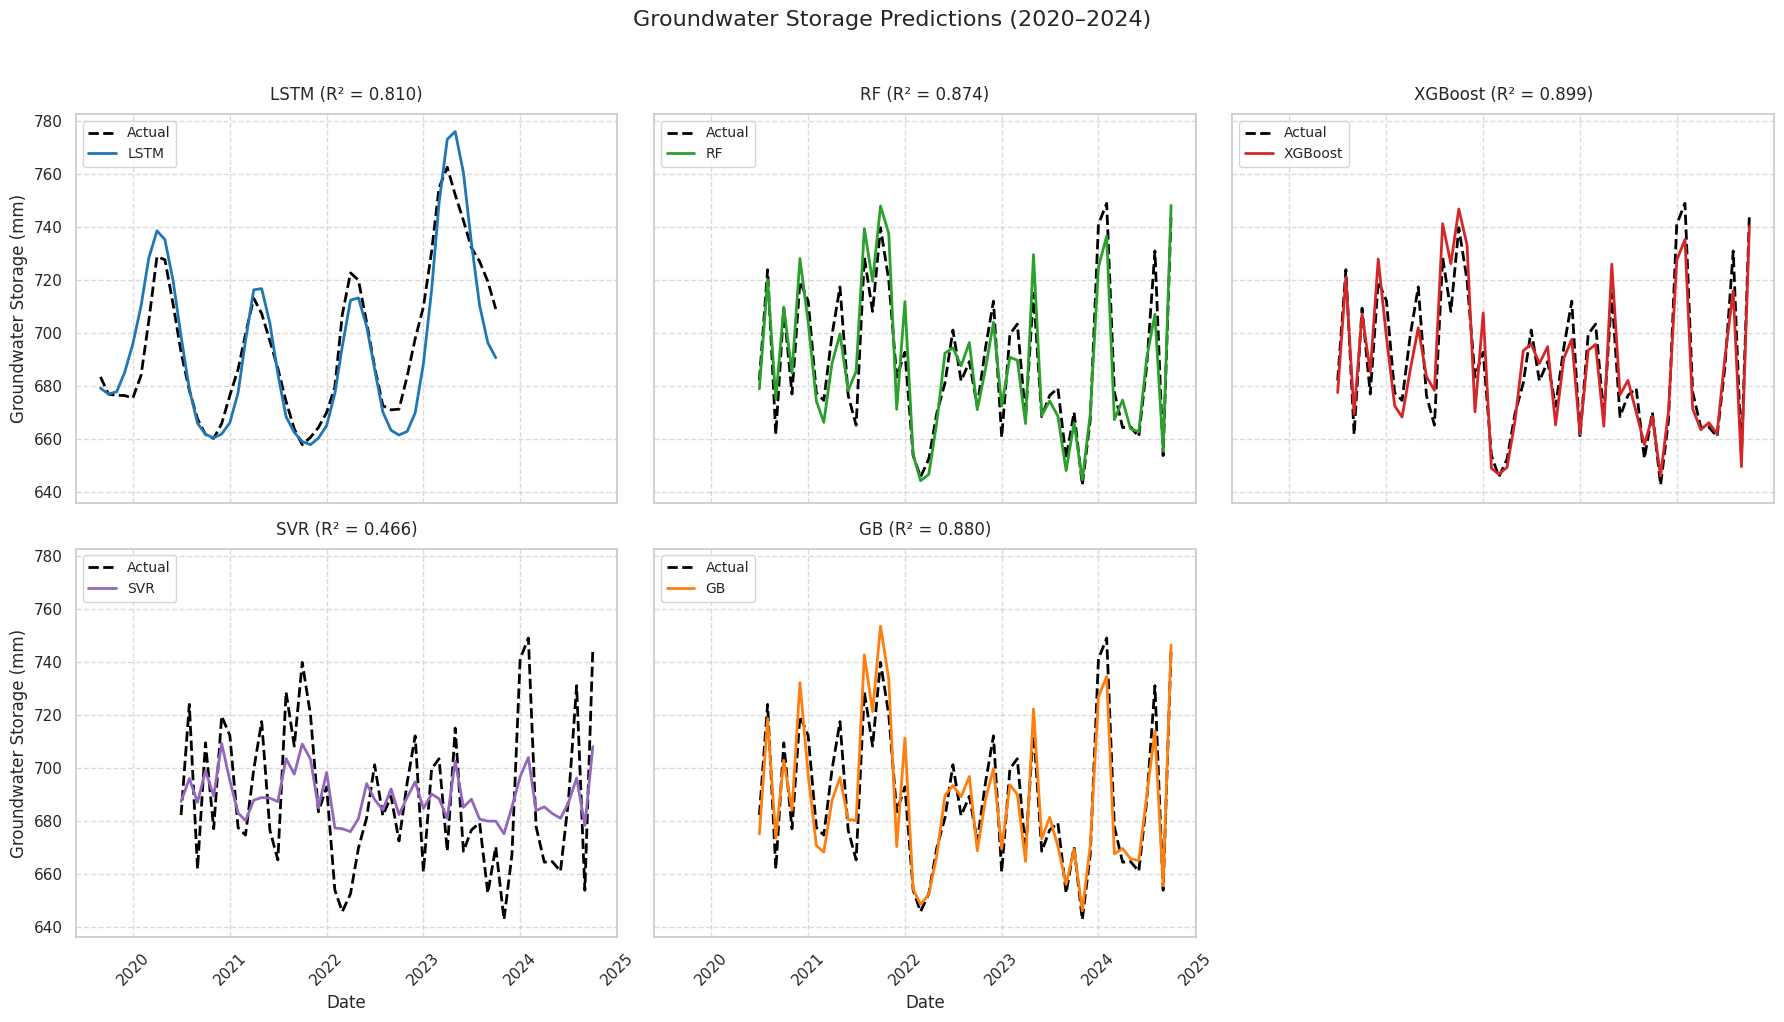


Groundwater Difference (Study - Control):
count    260.000000
mean    -142.896920
std       24.589104
min     -242.901954
25%     -151.824965
50%     -135.352123
75%     -127.286323
max     -109.498582
Name: gw_diff, dtype: float64


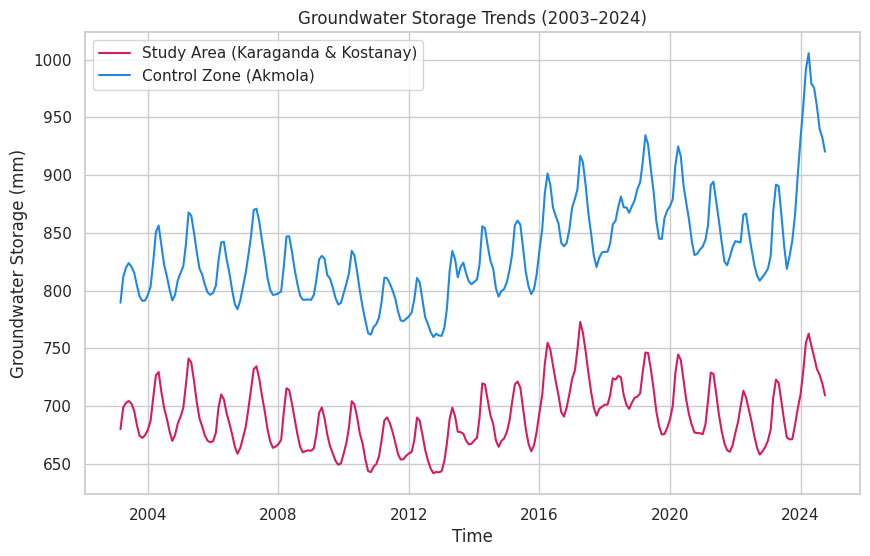


CSV Validation:
Rows: 260
Columns: ['system:index', 'control_et_mm_month', 'control_groundwater', 'control_rainfall_mm_month', 'control_snowfall_mm_month', 'control_soil_moisture', 'control_temperature', 'date', 'pixel_count_control', 'pixel_count_study', 'study_et_mm_month', 'study_groundwater', 'study_rainfall_mm_month', 'study_snowfall_mm_month', 'study_soil_moisture', 'study_temperature', '.geo', 'rainfall_lag1', 'et_lag1', 'soil_moisture_lag1', 'month', 'gw_diff']

Head:
  system:index  control_et_mm_month  control_groundwater  \
1   2003-03-01             9.220672           789.450904   
2   2003-04-01            30.741990           811.805810   
3   2003-05-01            70.145157           819.727734   
4   2003-06-01            97.110439           823.744892   
5   2003-07-01            81.285308           820.754284   

   control_rainfall_mm_month  control_snowfall_mm_month  \
1                  24.404309                  23.805423   
2                  21.263384           

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from scipy.stats import ranksums
import pymannkendall as mk
import tensorflow as tf

# Load CSV
df = pd.read_csv('/content/sample_data/2026ML_Feature_Table_Central_Kazakhstan.csv')

# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])

# Add lagged features
df['rainfall_lag1'] = df['study_rainfall_mm_month'].shift(1)
df['et_lag1'] = df['study_et_mm_month'].shift(1)
df['soil_moisture_lag1'] = df['study_soil_moisture'].shift(1)
df['month'] = df['date'].dt.month

# Drop rows with NaN
df = df.dropna()

# Define features and target
features = [
    'study_rainfall_mm_month', 'study_snowfall_mm_month',
    'study_soil_moisture', 'study_et_mm_month', 'study_temperature',
    'control_groundwater', 'rainfall_lag1', 'et_lag1', 'soil_moisture_lag1', 'month'
]
target = 'study_groundwater'

# --- Standard Models (RF, XGBoost, SVR, GB) ---
X = df[features]
y = df[target]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
dates_test_standard = df['date'].iloc[-len(y_test):].values

# Random Forest (tuned)
rf_params = {'n_estimators': [50, 100], 'max_depth': [5, 10, 15]}
rf_model = GridSearchCV(RandomForestRegressor(random_state=42), rf_params, cv=5)
rf_model.fit(X_train, y_train)
print("RF Best Parameters:", rf_model.best_params_)
rf_predictions = rf_model.predict(X_test)
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
rf_r2 = r2_score(y_test, rf_predictions)
print(f"RF: MAE={rf_mae:.4f}, RMSE={rf_rmse:.4f}, R²={rf_r2:.4f}")
rf_cv_scores = cross_val_score(rf_model.best_estimator_, X, y, cv=5, scoring='r2')
print(f"RF Cross-validated R²: {rf_cv_scores.mean():.4f} ± {rf_cv_scores.std():.4f}")

# XGBoost
xgb = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, reg_lambda=1, random_state=42)
xgb.fit(X_train, y_train)
xgb_predictions = xgb.predict(X_test)
xgb_mae = mean_absolute_error(y_test, xgb_predictions)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_predictions))
xgb_r2 = r2_score(y_test, xgb_predictions)
print(f"XGBoost: MAE={xgb_mae:.4f}, RMSE={xgb_rmse:.4f}, R²={xgb_r2:.4f}")
xgb_cv_scores = cross_val_score(xgb, X, y, cv=5, scoring='r2')
print(f"XGBoost Cross-validated R²: {xgb_cv_scores.mean():.4f} ± {xgb_cv_scores.std():.4f}")

# SVR (tuned)
svr_params = {'C': [0.1, 1, 10], 'epsilon': [0.01, 0.1]}
svr_model = GridSearchCV(SVR(), svr_params, cv=5)
svr_model.fit(X_train, y_train)
print("SVR Best Parameters:", svr_model.best_params_)
svr_predictions = svr_model.predict(X_test)
svr_mae = mean_absolute_error(y_test, svr_predictions)
svr_rmse = np.sqrt(mean_squared_error(y_test, svr_predictions))
svr_r2 = r2_score(y_test, svr_predictions)
print(f"SVR: MAE={svr_mae:.4f}, RMSE={svr_rmse:.4f}, R²={svr_r2:.4f}")
svr_cv_scores = cross_val_score(svr_model.best_estimator_, X, y, cv=5, scoring='r2')
print(f"SVR Cross-validated R²: {svr_cv_scores.mean():.4f} ± {svr_cv_scores.std():.4f}")

# Gradient Boosting (tuned)
gb_params = {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1]}
gb_model = GridSearchCV(GradientBoostingRegressor(random_state=42), gb_params, cv=5)
gb_model.fit(X_train, y_train)
print("GB Best Parameters:", gb_model.best_params_)
gb_predictions = gb_model.predict(X_test)
gb_mae = mean_absolute_error(y_test, gb_predictions)
gb_rmse = np.sqrt(mean_squared_error(y_test, gb_predictions))
gb_r2 = r2_score(y_test, gb_predictions)
print(f"GB: MAE={gb_mae:.4f}, RMSE={gb_rmse:.4f}, R²={gb_r2:.4f}")
gb_cv_scores = cross_val_score(gb_model.best_estimator_, X, y, cv=5, scoring='r2')
print(f"GB Cross-validated R²: {gb_cv_scores.mean():.4f} ± {gb_cv_scores.std():.4f}")

# --- LSTM Model ---
lstm_features = features + [target]
data = df[lstm_features]

# Normalize data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length, -1])
    return np.array(X), np.array(y)

seq_length = 12
X_lstm, y_lstm = create_sequences(data_scaled, seq_length)

# Train-test split
split = int(0.8 * len(X_lstm))
X_train_lstm, X_test_lstm = X_lstm[:split], X_lstm[split:]
y_train_lstm, y_test_lstm = y_lstm[:split], y_lstm[split:]
dates_test_lstm = df['date'].iloc[-(len(y_test_lstm) + seq_length): -seq_length].values

# Build LSTM model
def build_lstm_model():
    model = Sequential([
        Input(shape=(seq_length, len(lstm_features))),
        LSTM(50, return_sequences=True),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

lstm_model = build_lstm_model()
history = lstm_model.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=16,
                        validation_data=(X_test_lstm, y_test_lstm), verbose=0)
lstm_predictions = lstm_model.predict(X_test_lstm, batch_size=16, verbose=0).flatten()

# Inverse transform LSTM predictions and actuals
y_test_lstm_unscaled = scaler.inverse_transform(
    np.concatenate([X_test_lstm[:, -1, :-1], y_test_lstm.reshape(-1, 1)], axis=1)
)[:, -1]
lstm_predictions_unscaled = scaler.inverse_transform(
    np.concatenate([X_test_lstm[:, -1, :-1], lstm_predictions.reshape(-1, 1)], axis=1)
)[:, -1]

lstm_mae = mean_absolute_error(y_test_lstm_unscaled, lstm_predictions_unscaled)
lstm_rmse = np.sqrt(mean_squared_error(y_test_lstm_unscaled, lstm_predictions_unscaled))
lstm_r2 = r2_score(y_test_lstm_unscaled, lstm_predictions_unscaled)
print(f"LSTM: MAE={lstm_mae:.4f}, RMSE={lstm_rmse:.4f}, R²={lstm_r2:.4f}")

# --- Feature Importance (RF and GB) ---
feature_names = [
    'Rainfall', 'Snowfall', 'Soil Moisture', 'ET', 'Temperature',
    'Control Groundwater', 'Rainfall Lag1', 'ET Lag1', 'Soil Moisture Lag1', 'Month'
]

# Random Forest Feature Importance
rf_importances = rf_model.best_estimator_.feature_importances_
print("\nRandom Forest Feature Importance:")
for name, imp in zip(feature_names, rf_importances):
    print(f"{name}: {imp:.4f}")
plt.figure(figsize=(8, 5))
sns.barplot(x=rf_importances, y=feature_names, palette='viridis')
plt.title('Random Forest Feature Importance', fontsize=14, pad=10)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
for i, v in enumerate(rf_importances):
    plt.text(v + 0.005, i, f'{v:.3f}', va='center', fontsize=10)
plt.tight_layout()
plt.savefig('feature_importance_rf.png', dpi=300)
plt.show()

# Gradient Boosting Feature Importance
gb_importances = gb_model.best_estimator_.feature_importances_
print("\nGradient Boosting Feature Importance:")
for name, imp in zip(feature_names, gb_importances):
    print(f"{name}: {imp:.4f}")
plt.figure(figsize=(8, 5))
sns.barplot(x=gb_importances, y=feature_names, palette='viridis')
plt.title('Gradient Boosting Feature Importance', fontsize=14, pad=10)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
for i, v in enumerate(gb_importances):
    plt.text(v + 0.005, i, f'{v:.3f}', va='center', fontsize=10)
plt.tight_layout()
plt.savefig('feature_importance_gb.png', dpi=300)
plt.show()

# --- Statistical Tests ---
south_data = df.loc[df['date'].dt.year >= 2020, 'study_groundwater'][:len(y_test_lstm)]
north_data = df.loc[df['date'].dt.year >= 2020, 'control_groundwater'][:len(y_test_lstm)]
mk_south = mk.original_test(south_data)
print(f"Study Area Mann-Kendall: p={mk_south.p:.4f}, slope={mk_south.slope:.4f}")
wilcoxon_stat, wilcoxon_p = ranksums(south_data, north_data)
print(f"Wilcoxon p-value: {wilcoxon_p:.4f}")

# --- Predictions Plot ---
sns.set(style='whitegrid')
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=True, sharey=True)
axes = axes.flatten()
models = ['LSTM', 'RF', 'XGBoost', 'SVR', 'GB']
predictions = [
    lstm_predictions_unscaled, rf_predictions, xgb_predictions,
    svr_predictions, gb_predictions
]
r2_values = [lstm_r2, rf_r2, xgb_r2, svr_r2, gb_r2]
colors = ['#1f77b4', '#2ca02c', '#d62728', '#9467bd', '#ff7f0e']

for i, (model, pred, r2, color) in enumerate(zip(models, predictions, r2_values, colors)):
    dates = dates_test_lstm if model == 'LSTM' else dates_test_standard
    y_actual = y_test_lstm_unscaled if model == 'LSTM' else y_test
    axes[i].plot(dates[:len(y_actual)], y_actual, label='Actual', color='black', lw=2, linestyle='--')
    axes[i].plot(dates[:len(pred)], pred, label=model, color=color, lw=2)
    axes[i].set_title(f'{model} (R² = {r2:.3f})', fontsize=12, pad=10)
    axes[i].legend(loc='upper left', fontsize=10)
    axes[i].grid(True, linestyle='--', alpha=0.7)
    if i >= 3:
        axes[i].set_xlabel('Date', fontsize=12)
    if i % 3 == 0:
        axes[i].set_ylabel('Groundwater Storage (mm)', fontsize=12)
    axes[i].tick_params(axis='x', rotation=45)

# Hide empty subplot
axes[-1].axis('off')

plt.suptitle('Groundwater Storage Predictions (2020–2024)', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('predictions_all.png', dpi=300)
plt.show()

# --- Groundwater Difference ---
df['gw_diff'] = df['study_groundwater'] - df['control_groundwater']
print("\nGroundwater Difference (Study - Control):")
print(df['gw_diff'].describe())

# --- Trend Plot ---
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['study_groundwater'], label='Study Area (Karaganda & Kostanay)', color='#D81B60')
plt.plot(df['date'], df['control_groundwater'], label='Control Zone (Akmola)', color='#1E88E5')
plt.title('Groundwater Storage Trends (2003–2024)')
plt.xlabel('Time')
plt.ylabel('Groundwater Storage (mm)')
plt.legend()
plt.grid(True)
plt.savefig('groundwater_trends.png', dpi=300)
plt.show()

# --- CSV Validation ---
print("\nCSV Validation:")
print("Rows:", len(df))
print("Columns:", df.columns.tolist())
print("\nHead:")
print(df.head())
print("\nDescribe:")
print(df.describe())
print("\nNulls:")
print(df.isnull().sum())